# Práctica 2

Procesamiento de Lenguaje Natural
Facultad de Ingeniería, UNAM

González Flores Andrés

## Instrucciones

A partir del corpus proporcionado ("corpusML.txt") realizar un modelo del lenguaje neuronal con base en la arquitectura propuesta por Bengio (2003).

Síganse los siguientes pasos:

1. Limpiar los textos y aplicar stemming a las palabras.
2. Insertar símbolos de inicio y final de cadena.
3. Obtener los bigramas que aparecen en el texto (indexar numéricamente).
4. Entrenar con los bigramas la red neuronal y obtener los valores para los hiperparámetros. Tomar de 100 unidades para la primera capa oculta (capa lineal) y 300 para la segunda capa oculta (capa con tanh).
5. Obtener las matrices $A$ y $\Pi$ a partir de las salidas de la red neuornal (probabilidad Softmax).
6. Evaluar el modelo (con Entropía).
7. Calcular la proabilidad de las siguientes oraciones:
    - Nos bañamos con agua caliente
    - El animalito le olía la cabeza
    - Pascuala ordeñaba las vacas

## Desarrollo

In [1]:
# Importar módulos
import numpy as np
import re
from nltk import SnowballStemmer
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from itertools import chain
from tqdm.notebook import tqdm as nbtqdm
from tqdm.auto import tqdm

In [2]:
# Definición de constantes
np.random.seed(420)
stemmer_esp = SnowballStemmer('spanish')
CORPUS_PATH = './Data/corpusML.txt'
BOS = '<BOS>'
EOS = '<EOS>'
UNK = '<unk>'

### Paso 1

Limpiar los textos y aplicar stemming a las palabras.

In [3]:
with open(CORPUS_PATH, 'r', encoding='utf-8') as f:
    corpus = [
        list(map(lambda token: stemmer_esp.stem(token), # Mapeo cada token a su stem
            re.findall('[a-zA-zñáéíóúü]+', linea.lower()) # Devuelve una lista con todas las ocurrencias que coincidan con la regex
        ))
        for linea in f
    ]
    for docs in corpus[:5]:
        print(docs) # Muestro 5 ejemplos

['comenc', 'a', 'trabaj', 'y', 'me', 'peg', 'me', 'maltrat', 'con', 'chicot']
['mis', 'patron', 'me', 'peg', 'porqu', 'no', 'me', 'quer', 'apur', 'porqu', 'era', 'floj']
['por', 'eso', 'me', 'hab', 'peg']
['cuand', 'me', 'peg', 'ya', 'entonc', 'me', 'quit']
['pues', 'entonc', 'no', 'quis', 'trabaj']


Divido el corpus en entrenamiento y evaluación

In [4]:
train_corpus, eval_corpus = train_test_split(corpus, test_size=0.3)

print(f'\nTamaño del corpus de entrenamiento: {len(train_corpus)}')
print('Ejemplos:')
for docs in train_corpus[:5]:
        print(docs) # Muestro 5 ejemplos

print(f'\nTamaño del corpus de evaluación: {len(eval_corpus)}')
print('Ejemplos:')
for docs in eval_corpus[:5]:
        print(' ', docs) # Muestro 5 ejemplos


Tamaño del corpus de entrenamiento: 751
Ejemplos:
['per', 'pues', 'si', 'el', 'padr', 'del', 'hombr', 'quer', 'lo', 'iba', 'a', 'dej']
['hem', 'fabric', 'un', 'temascal', 'par', 'bañ']
['ni', 'par', 'el', 'jabon', 'encontr']
['mi', 'difunt', 'padrecit', 'fue', 'qui', 'me', 'cur']
['se', 'traslad', 'de', 'igual', 'maner', 'y', 'se', 'le', 'mov', 'el', 'pal']

Tamaño del corpus de evaluación: 323
Ejemplos:
  ['y', 'cuart', 'par', 'que', 'vay', 'dos', 'segund', 'palm']
  ['le', 'dig', 'pues', 'que', 'no', 'es', 'tu', 'tambor', 'le', 'dig']
  ['com', 'tambien', 'se', 'llen', 'de', 'agu']
  ['juan', 'se', 'cay', 'del', 'tech']
  ['sobr', 'un', 'refresquit', 'y', 'algo', 'de', 'vinit']


Muestro la curva de zipf

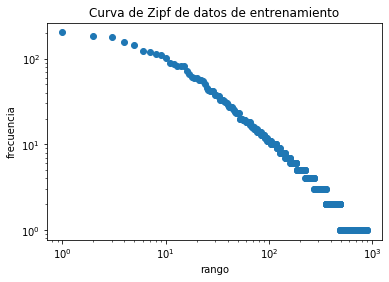

In [5]:
frec = sum([Counter(doc) for doc in train_corpus], Counter())

plt.plot(sorted(frec.values(), reverse=True), 'o')
plt.xlabel('rango')
plt.ylabel('frecuencia')
plt.xscale('log')
plt.yscale('log')
plt.title('Curva de Zipf de datos de entrenamiento')
plt.show()

Sustituyo los hapax por el identificador <unk\>

In [6]:
train_corpus_unk = [
    [
        # Si la frecuencia de la palabra es 1, se sustituye por UNK
        (UNK if frec[w] == 1 else w)
        for w in doc
    ] 
    for doc in train_corpus 
]

print('Ejemplos:')
for docs in train_corpus_unk[:5]:
        print(docs) # Muestro 5 ejemplos

Ejemplos:
['per', 'pues', 'si', 'el', 'padr', 'del', 'hombr', 'quer', 'lo', 'iba', 'a', 'dej']
['hem', 'fabric', 'un', 'temascal', 'par', 'bañ']
['ni', 'par', 'el', 'jabon', 'encontr']
['mi', 'difunt', 'padrecit', 'fue', 'qui', 'me', 'cur']
['se', 'traslad', 'de', 'igual', '<unk>', 'y', 'se', 'le', 'mov', 'el', 'pal']


### Paso 2

Insertar símbolos de inicio y final de cadena.

In [7]:
train_corpus_unk = list(map(lambda doc: [BOS, *doc, EOS], train_corpus_unk))
for doc in train_corpus_unk[:5]:
    print(doc)

['<BOS>', 'per', 'pues', 'si', 'el', 'padr', 'del', 'hombr', 'quer', 'lo', 'iba', 'a', 'dej', '<EOS>']
['<BOS>', 'hem', 'fabric', 'un', 'temascal', 'par', 'bañ', '<EOS>']
['<BOS>', 'ni', 'par', 'el', 'jabon', 'encontr', '<EOS>']
['<BOS>', 'mi', 'difunt', 'padrecit', 'fue', 'qui', 'me', 'cur', '<EOS>']
['<BOS>', 'se', 'traslad', 'de', 'igual', '<unk>', 'y', 'se', 'le', 'mov', 'el', 'pal', '<EOS>']


### Paso 3

Obtener los bigramas que aparecen en el texto (indexar numéricamente).

In [8]:
# Indexo numéricamente los stems
vocab = defaultdict() 
# El método default_factory sirve para asignar un nuevo valor por defecto
# en caso de no encontrar el indice dado
vocab.default_factory = lambda: len(vocab)

# Indexo numéricamente las palabras en los documentos
corpus_ids = [[vocab[w] for w in doc] for doc in train_corpus_unk]

print('Ejemplos de palabras en el vocabulario')
for palabra, i in list(vocab.items())[:10]:
    print(f'  {palabra} : {i}')

print('\nEjemplos de oraciones indexadas numéricamente')
for doc in corpus_ids[:6]:
    print(' ', doc)

Ejemplos de palabras en el vocabulario
  <BOS> : 0
  per : 1
  pues : 2
  si : 3
  el : 4
  padr : 5
  del : 6
  hombr : 7
  quer : 8
  lo : 9

Ejemplos de oraciones indexadas numéricamente
  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
  [0, 14, 15, 16, 17, 18, 19, 13]
  [0, 20, 18, 4, 21, 22, 13]
  [0, 23, 24, 25, 26, 27, 28, 29, 13]
  [0, 30, 31, 32, 33, 34, 35, 30, 36, 37, 4, 38, 13]
  [0, 39, 40, 41, 42, 18, 43, 13]


In [9]:
inv_vocab = { item : key for key, item in vocab.items()}

```doc[:-1]``` toma todos las cadenas de un documento (frase) excepto la última

```doc[1:]``` toma todos las cadenas de un documento (frase) excepto la primera

Con zip, uno una cadena de la primer lista con una de la segunda en tuplas (bigramas)

In [10]:
bigramas = [bi for doc in train_corpus_unk for bi in zip(doc[:-1], doc[1:])]

bigramas[:20] # Ejemplos con cadenas

[('<BOS>', 'per'),
 ('per', 'pues'),
 ('pues', 'si'),
 ('si', 'el'),
 ('el', 'padr'),
 ('padr', 'del'),
 ('del', 'hombr'),
 ('hombr', 'quer'),
 ('quer', 'lo'),
 ('lo', 'iba'),
 ('iba', 'a'),
 ('a', 'dej'),
 ('dej', '<EOS>'),
 ('<BOS>', 'hem'),
 ('hem', 'fabric'),
 ('fabric', 'un'),
 ('un', 'temascal'),
 ('temascal', 'par'),
 ('par', 'bañ'),
 ('bañ', '<EOS>')]

In [11]:
bigramas_ids = [bi for doc in corpus_ids for bi in zip(doc[:-1], doc[1:])]
bigramas_ids[:20] # Ejemplos de bigramas indexados numéricamente

[(0, 1),
 (1, 2),
 (2, 3),
 (3, 4),
 (4, 5),
 (5, 6),
 (6, 7),
 (7, 8),
 (8, 9),
 (9, 10),
 (10, 11),
 (11, 12),
 (12, 13),
 (0, 14),
 (14, 15),
 (15, 16),
 (16, 17),
 (17, 18),
 (18, 19),
 (19, 13)]

### Paso 4

Entrenar con los bigramas la red neuronal y obtener los valores para los hiperparámetros. Tomar de 100 unidades para la primera capa oculta (capa lineal) y 300 para la segunda capa oculta (capa con tanh).

In [12]:
# Hiperparámetros
d = 100# 100
m = 300# 300
epochs = 300
lr = 0.1
# Constantes
N = len(vocab)
print('Tamaño del vocabulario: ', N)

Tamaño del vocabulario: 493


Modelo

Defino la matriz de la primer capa oculta (embedding). $ C \in \mathbb{R}^{d \times N} $.

In [13]:
class Bengio2003:
    # m = 10
    # d = 2
    # N = 0
    # bigramas = []
    # C = []
    # W = []
    # b = []
    # U = []
    # c = []
    # h = []
    def __init__(self, bigramas, d, m, N):
        self.d = d
        self.m = m
        self.N = N
        self.bigramas = bigramas

    def inicializar_pesos(self):
        self.C = np.random.random((d, N))
        self.W = np.random.random((m, d))
        self.b = np.random.random(m)
        self.U = np.random.random((N, m))
        self.c = np.random.random(N)
    
    def forward(self, i_x):
        # La capa embedding se reduce a C_1[:, i_x]
        h_i = np.tanh(np.dot(self.W, self.C[:, i_x]) + self.b) # Segunda capa oculta
        # print('h_i: ', self.h)
        a = self.U.dot(h_i) + self.c # Preactivación
        # print('a: ', a)
        exp_a = np.exp(a - a.max()) # Exponencial de la preactivación
        prob_salida = exp_a/exp_a.sum() # Capa de salida softmax
        return (prob_salida, h_i)

    def backprop(self, i_x, i_y, prob_salida, h_i, lr=0.1):
        y_pred = np.argmax(prob_salida) # El índice de la palabra que predijo
        # print('y_pred: ', y_pred)
        
        # Backprop
        d_out = np.array(prob_salida, copy=True) #.reshape(N, 1)
        # print('Dimensiones d_out: ', d_out.shape)
        d_out[i_y] -= 1  # p(w_k | w_i) - y_k
        # print('d_out: ', d_out)
        d_h = (1-h_i**2)*np.dot(d_out.T, self.U)
        # print('d_h: ', d_h)
        # print('Dimensiones d_h: ', d_h.shape)
        d_c = np.dot(d_h.T, self.W)
        # print('d_c: ', d_c)
        # print('Dimensiones d_c: ', d_c.shape)

        # Actualizamos los pesos
        # self.U -= lr*d_out.reshape(self.N, 1)*self.h.reshape(1, self.m)
        self.U -= lr*np.outer(d_out, h_i) # d_out.reshape(self.N, 1)*self.h.reshape(1, self.m)
        # print('U: ', self.U)
        # print('Dimensiones U: ', self.U.shape)
        self.c -= lr*d_out
        # print('c: ', self.c)
        # print('Dimensiones c: ', self.c.shape)
        self.W -= lr*np.outer(d_h, self.C[:,i_x]) #d_h.reshape(self.m, 1)*self.C[:,i_x].reshape(1,self.d)
        # print('W: ', self.W)
        # print('Dimensiones W: ', self.W.shape)
        self.b -= lr*d_h
        # print('b: ', self.b)
        # print('Dimensiones b: ', self.b.shape)
        self.C[:, i_x] -= lr*d_c # Las demás filas no nos interesan, porque son 0
        # print('C: ', self.C)
        # print('Dimensiones C: ', self.C.shape)
        # return ((U, c), (W, b), C)

    def predecir(self, i_x):
        return np.argmax(self.forward(i_x)[0])
    
    # def f_costo(self):
    #     pass
    
    def entrenar(self, epochs=50, lr=0.1):
        entr_timeline = []
        for epoch in nbtqdm(range(epochs)):
            np.random.shuffle(bigramas)
            cross_entropy = 0
            for bigrama in self.bigramas:
                i_x = bigrama[0] # El índice de la primer palabra del bigrama
                i_y = bigrama[1] # El índice de la segunda palabra del bigrama
                # print(f'  Bigrama: {inv_vocab[i_x]} {inv_vocab[i_y]}')
                prob_salida, h_i = self.forward(i_x)
                # print(f'  Predicción: {inv_vocab[i_x]} {inv_vocab[np.argmax(prob_salida)]}')
                self.backprop(i_x, i_y, prob_salida, h_i)
                cross_entropy -= np.log(prob_salida[i_y])
            entr_timeline.append(cross_entropy)
            tqdm.write(f'Epoch: {epoch+1} \tEntropía cruzada: {cross_entropy}')
        return entr_timeline


In [14]:
modelo = Bengio2003(bigramas_ids, d, m, N)
modelo.inicializar_pesos()
hist_entropia = modelo.entrenar(epochs)

Epoch: 1 	Entropía cruzada: 207578.99514238857
Epoch: 2 	Entropía cruzada: 207599.8393208843
Epoch: 3 	Entropía cruzada: 207599.80155395294
Epoch: 4 	Entropía cruzada: 207599.7819102326
Epoch: 5 	Entropía cruzada: 207599.76953293933
Epoch: 6 	Entropía cruzada: 207599.76089552746
Epoch: 7 	Entropía cruzada: 207599.7544666475
Epoch: 8 	Entropía cruzada: 207599.74946320738
Epoch: 9 	Entropía cruzada: 207599.74543928468
Epoch: 10 	Entropía cruzada: 207599.7421206619
Epoch: 11 	Entropía cruzada: 207599.73932864834
Epoch: 12 	Entropía cruzada: 207599.7369413936
Epoch: 13 	Entropía cruzada: 207599.73487270979
Epoch: 14 	Entropía cruzada: 207599.73305977375
Epoch: 15 	Entropía cruzada: 207599.73145561817
Epoch: 16 	Entropía cruzada: 207599.73002436786
Epoch: 17 	Entropía cruzada: 207599.72873810932
Epoch: 18 	Entropía cruzada: 207599.7275747649
Epoch: 19 	Entropía cruzada: 207599.7265166356
Epoch: 20 	Entropía cruzada: 207599.72554933658
Epoch: 21 	Entropía cruzada: 207599.72466106183
Epoch: 2

In [18]:
print(f'{inv_vocab[100]} {inv_vocab[np.argmax(modelo.forward(100)[0])]}')
print(f'{inv_vocab[12]} {inv_vocab[np.argmax(modelo.forward(12)[0])]}')
print(f'{inv_vocab[200]} {inv_vocab[np.argmax(modelo.forward(200)[0])]}')
# print(f'{inv_vocab[0]} {inv_vocab[modelo.predecir(0)]}')
# print(f'{inv_vocab[12]} {inv_vocab[modelo.predecir(12)]}')
# print(f'{inv_vocab[200]} {inv_vocab[modelo.predecir(200)]}')

hast <EOS>
dej <EOS>
orill <EOS>


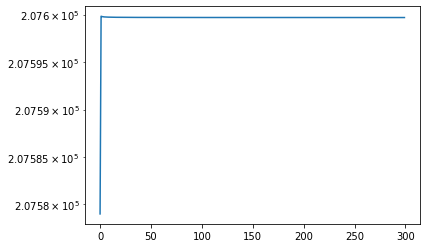

In [17]:
plt.plot(hist_entropia)
plt.yscale('log')
plt.show()